# Tamas Flesch Thesis - Linear regression step

## LMJU - UpGrad - DS

### Fifa 23 Ultimate Team player price prediction based on the player's attributes

<span style="color:red">*UPDATE*</span>

The document was updated with the latest EA FC 24 dataset to be able to compare the results with the previous FIFA 23 dataset.

Table of contents
1. Read data
2. Price distribution analysis
3. Test-Train Split
4. Feature Scaling
5. Feature Selection Using RFE
6. Building model using statsmodel, for the detailed statistics
7. Residual Analysis of the train data
8. Making Predictions Using the Final Model
9. Model evaluation
10. UPDATE FOR EA FC 24:
   - data segmentations

### 1. Read data

#### Imports

In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Importing Pandas and NumPy
import pandas as pd, numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_percentage_error

import statsmodels.api as sm

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
# Importing all datasets
futbin_data = pd.read_csv("futbin24.csv")
futbin_data.head()

,Name,Rating,Price,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Height_in_cm,BodyType_Weight,Club_Hero,Alt_Pos_Count,Main_Position_CB,Main_Position_CDM,Main_Position_CF,Main_Position_CM,Main_Position_GK,Main_Position_LB,Main_Position_LM,Main_Position_LW,Main_Position_LWB,Main_Position_RB,Main_Position_RM,Main_Position_RW,Main_Position_RWB,Main_Position_ST,Run_Style_Controlled Explosive,Run_Style_Controlled Lengthy,Run_Style_Explosive,Run_Style_Lengthy,Run_Style_Mostly Explosive,Run_Style_Mostly Lengthy,Attack_Workrate_L,Attack_Workrate_M,Defense_Workrate_L,Defense_Workrate_M,BodyType_Text_Avg & Normal,BodyType_Text_Avg & Stocky,BodyType_Text_CR7,BodyType_Text_Courtois,BodyType_Text_Messi,BodyType_Text_Neymar,BodyType_Text_R9,BodyType_Text_Ronaldinho,BodyType_Text_Salah,BodyType_Text_Shaqiri,BodyType_Text_Short & Lean,BodyType_Text_Short & Normal,BodyType_Text_Short & Stocky,BodyType_Text_Tall & Lean,BodyType_Text_Tall & Normal,BodyType_Text_Tall & Stocky,BodyType_Text_Unique,League_Cat_Icons,League_Cat_LALIGA EA SPORTS,League_Cat_Ligue 1 Uber Eats,League_Cat_MLS,League_Cat_Other,League_Cat_Premier League,League_Cat_Serie A TIM,Nation_Cat_Brazil,Nation_Cat_England,Nation_Cat_France,Nation_Cat_Germany,Nation_Cat_Holland,Nation_Cat_Italy,Nation_Cat_Other,Nation_Cat_Portugal,Nation_Cat_Spain,Nation_Cat_United States,Alt_Pos_1_CB,Alt_Pos_1_CDM,Alt_Pos_1_CF,Alt_Pos_1_CM,Alt_Pos_1_LB,Alt_Pos_1_LM,Alt_Pos_1_LW,Alt_Pos_1_LWB,Alt_Pos_1_RB,Alt_Pos_1_RM,Alt_Pos_1_RW,Alt_Pos_1_RWB,Alt_Pos_1_ST,Alt_Pos_1_missing,Alt_Pos_2_CB,Alt_Pos_2_CDM,Alt_Pos_2_CF,Alt_Pos_2_CM,Alt_Pos_2_LB,Alt_Pos_2_LM,Alt_Pos_2_LW,Alt_Pos_2_LWB,Alt_Pos_2_RB,Alt_Pos_2_RM,Alt_Pos_2_RW,Alt_Pos_2_ST,Alt_Pos_2_missing,Alt_Pos_3_CDM,Alt_Pos_3_CF,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing,Gender_Male
0,Erling Haaland,97,1980000.0,4,5,96.0,98,80,91,56,97,1645,518,2481,195,94,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
1,Kylian Mbappé,97,6250000.0,5,4,99.0,96,88,97,47,88,1651,515,2465,182,75,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,Lionel Messi,97,2830000.0,5,4,91.0,96,97,98,40,77,-4941,499,2430,169,67,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,Pelé,97,6400000.0,5,5,95.0,96,92,96,60,81,272,520,2532,173,70,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1
4,Johan Cruyff,97,3550000.0,5,5,93.0,95,93,97,50,80,159,508,2460,180,71,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1


In [36]:
futbin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8997 entries, 0 to 8996
Columns: 115 entries, Name to Gender_Male
dtypes: float64(2), int64(112), object(1)
memory usage: 7.9+ MB


In [37]:
len(futbin_data[futbin_data.Price > 100000])

560

In [38]:
560/8997*100

6.22429698788485

It seems to me that the Price are a little bit strange variable, there are some outliers in the data. 

We have only 560 players in the database which have a the Price greater than 100.000. Which is almost 6.23%.

I will create two models, one for the 'average' players and one for the extra expensive players. It will be interesting to compare what are the important features for the two groups.

In [39]:
average_players = futbin_data[futbin_data.Price < 100000]

In [40]:
average_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8435 entries, 36 to 8996
Columns: 115 entries, Name to Gender_Male
dtypes: float64(2), int64(112), object(1)
memory usage: 7.5+ MB


In [41]:
star_players = futbin_data[futbin_data.Price >= 100000]

In [42]:
star_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 562 entries, 0 to 7948
Columns: 115 entries, Name to Gender_Male
dtypes: float64(2), int64(112), object(1)
memory usage: 509.3+ KB


### 2. Price distribution analysis

In [43]:
futbin_data.Price.describe()

count    8.997000e+03
mean     4.271950e+04
std      2.642732e+05
min      2.000000e+02
25%      2.000000e+02
50%      4.000000e+02
75%      4.500000e+03
max      8.200000e+06
Name: Price, dtype: float64

In [44]:
len(futbin_data[futbin_data.Price == 0])

0

<Axes: ylabel='Frequency'>

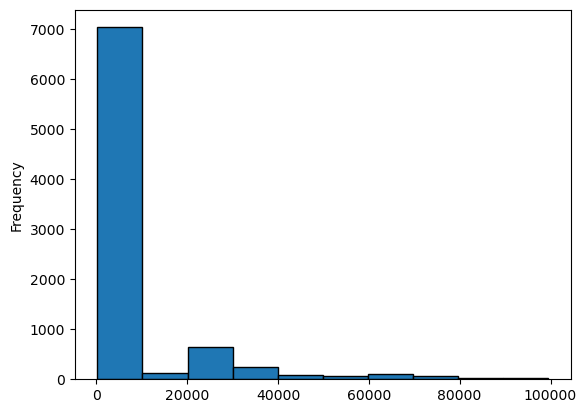

In [45]:
#plot distribution of values in price column
average_players['Price'].plot(kind='hist', edgecolor='black')

<Axes: ylabel='Frequency'>

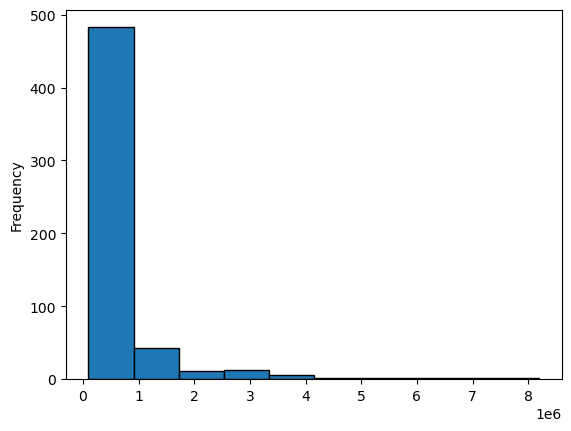

In [46]:
star_players['Price'].plot(kind='hist', edgecolor='black')

### 3. Test-Train Split

#### average

In [47]:
# Putting feature variable to X
X_avg = average_players.drop(['Name','Price'], axis=1)

X_avg.head()

,Rating,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Height_in_cm,BodyType_Weight,Club_Hero,Alt_Pos_Count,Main_Position_CB,Main_Position_CDM,Main_Position_CF,Main_Position_CM,Main_Position_GK,Main_Position_LB,Main_Position_LM,Main_Position_LW,Main_Position_LWB,Main_Position_RB,Main_Position_RM,Main_Position_RW,Main_Position_RWB,Main_Position_ST,Run_Style_Controlled Explosive,Run_Style_Controlled Lengthy,Run_Style_Explosive,Run_Style_Lengthy,Run_Style_Mostly Explosive,Run_Style_Mostly Lengthy,Attack_Workrate_L,Attack_Workrate_M,Defense_Workrate_L,Defense_Workrate_M,BodyType_Text_Avg & Normal,BodyType_Text_Avg & Stocky,BodyType_Text_CR7,BodyType_Text_Courtois,BodyType_Text_Messi,BodyType_Text_Neymar,BodyType_Text_R9,BodyType_Text_Ronaldinho,BodyType_Text_Salah,BodyType_Text_Shaqiri,BodyType_Text_Short & Lean,BodyType_Text_Short & Normal,BodyType_Text_Short & Stocky,BodyType_Text_Tall & Lean,BodyType_Text_Tall & Normal,BodyType_Text_Tall & Stocky,BodyType_Text_Unique,League_Cat_Icons,League_Cat_LALIGA EA SPORTS,League_Cat_Ligue 1 Uber Eats,League_Cat_MLS,League_Cat_Other,League_Cat_Premier League,League_Cat_Serie A TIM,Nation_Cat_Brazil,Nation_Cat_England,Nation_Cat_France,Nation_Cat_Germany,Nation_Cat_Holland,Nation_Cat_Italy,Nation_Cat_Other,Nation_Cat_Portugal,Nation_Cat_Spain,Nation_Cat_United States,Alt_Pos_1_CB,Alt_Pos_1_CDM,Alt_Pos_1_CF,Alt_Pos_1_CM,Alt_Pos_1_LB,Alt_Pos_1_LM,Alt_Pos_1_LW,Alt_Pos_1_LWB,Alt_Pos_1_RB,Alt_Pos_1_RM,Alt_Pos_1_RW,Alt_Pos_1_RWB,Alt_Pos_1_ST,Alt_Pos_1_missing,Alt_Pos_2_CB,Alt_Pos_2_CDM,Alt_Pos_2_CF,Alt_Pos_2_CM,Alt_Pos_2_LB,Alt_Pos_2_LM,Alt_Pos_2_LW,Alt_Pos_2_LWB,Alt_Pos_2_RB,Alt_Pos_2_RM,Alt_Pos_2_RW,Alt_Pos_2_ST,Alt_Pos_2_missing,Alt_Pos_3_CDM,Alt_Pos_3_CF,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing,Gender_Male
36,96,4,5,97.0,93,90,92,64,94,1188,530,2581,169,69,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
52,95,3,3,96.0,91,88,95,72,92,-13,534,1051,196,90,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
59,95,3,4,93.0,95,90,97,76,94,50,545,1042,183,79,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
67,94,4,4,83.0,95,85,92,49,88,2186,492,2401,185,81,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
95,94,3,3,93.0,92,92,96,64,94,245,531,1118,193,91,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1


In [48]:
# Putting response variable to y
y_avg = average_players['Price']

y_avg.head()

36    65300.0
52    49000.0
59    47000.0
67    75000.0
95    69000.0
Name: Price, dtype: float64

In [49]:
# Splitting the average data into train and test
X_avg_train, X_avg_test, y_avg_train, y_avg_test = train_test_split(X_avg, y_avg, train_size=0.8, test_size=0.2, random_state=100)

#### star

In [50]:
# Putting feature variable to X
X_star = star_players.drop(['Name','Price'], axis=1)

X_star.head()

,Rating,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Height_in_cm,BodyType_Weight,Club_Hero,Alt_Pos_Count,Main_Position_CB,Main_Position_CDM,Main_Position_CF,Main_Position_CM,Main_Position_GK,Main_Position_LB,Main_Position_LM,Main_Position_LW,Main_Position_LWB,Main_Position_RB,Main_Position_RM,Main_Position_RW,Main_Position_RWB,Main_Position_ST,Run_Style_Controlled Explosive,Run_Style_Controlled Lengthy,Run_Style_Explosive,Run_Style_Lengthy,Run_Style_Mostly Explosive,Run_Style_Mostly Lengthy,Attack_Workrate_L,Attack_Workrate_M,Defense_Workrate_L,Defense_Workrate_M,BodyType_Text_Avg & Normal,BodyType_Text_Avg & Stocky,BodyType_Text_CR7,BodyType_Text_Courtois,BodyType_Text_Messi,BodyType_Text_Neymar,BodyType_Text_R9,BodyType_Text_Ronaldinho,BodyType_Text_Salah,BodyType_Text_Shaqiri,BodyType_Text_Short & Lean,BodyType_Text_Short & Normal,BodyType_Text_Short & Stocky,BodyType_Text_Tall & Lean,BodyType_Text_Tall & Normal,BodyType_Text_Tall & Stocky,BodyType_Text_Unique,League_Cat_Icons,League_Cat_LALIGA EA SPORTS,League_Cat_Ligue 1 Uber Eats,League_Cat_MLS,League_Cat_Other,League_Cat_Premier League,League_Cat_Serie A TIM,Nation_Cat_Brazil,Nation_Cat_England,Nation_Cat_France,Nation_Cat_Germany,Nation_Cat_Holland,Nation_Cat_Italy,Nation_Cat_Other,Nation_Cat_Portugal,Nation_Cat_Spain,Nation_Cat_United States,Alt_Pos_1_CB,Alt_Pos_1_CDM,Alt_Pos_1_CF,Alt_Pos_1_CM,Alt_Pos_1_LB,Alt_Pos_1_LM,Alt_Pos_1_LW,Alt_Pos_1_LWB,Alt_Pos_1_RB,Alt_Pos_1_RM,Alt_Pos_1_RW,Alt_Pos_1_RWB,Alt_Pos_1_ST,Alt_Pos_1_missing,Alt_Pos_2_CB,Alt_Pos_2_CDM,Alt_Pos_2_CF,Alt_Pos_2_CM,Alt_Pos_2_LB,Alt_Pos_2_LM,Alt_Pos_2_LW,Alt_Pos_2_LWB,Alt_Pos_2_RB,Alt_Pos_2_RM,Alt_Pos_2_RW,Alt_Pos_2_ST,Alt_Pos_2_missing,Alt_Pos_3_CDM,Alt_Pos_3_CF,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing,Gender_Male
0,97,4,5,96.0,98,80,91,56,97,1645,518,2481,195,94,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
1,97,5,4,99.0,96,88,97,47,88,1651,515,2465,182,75,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,97,5,4,91.0,96,97,98,40,77,-4941,499,2430,169,67,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,97,5,5,95.0,96,92,96,60,81,272,520,2532,173,70,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1
4,97,5,5,93.0,95,93,97,50,80,159,508,2460,180,71,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1


In [51]:
# Putting response variable to y
y_star = star_players['Price']

y_star.head()

0    1980000.0
1    6250000.0
2    2830000.0
3    6400000.0
4    3550000.0
Name: Price, dtype: float64

In [52]:
# Splitting the star data into train and test
X_star_train, X_star_test, y_star_train, y_star_test = train_test_split(X_star, y_star, train_size=0.8, test_size=0.2, random_state=100)

#### full data

In [53]:
# Putting feature variable to X
X_full = futbin_data.drop(['Name','Price'], axis=1)

X_full.head()

,Rating,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Height_in_cm,BodyType_Weight,Club_Hero,Alt_Pos_Count,Main_Position_CB,Main_Position_CDM,Main_Position_CF,Main_Position_CM,Main_Position_GK,Main_Position_LB,Main_Position_LM,Main_Position_LW,Main_Position_LWB,Main_Position_RB,Main_Position_RM,Main_Position_RW,Main_Position_RWB,Main_Position_ST,Run_Style_Controlled Explosive,Run_Style_Controlled Lengthy,Run_Style_Explosive,Run_Style_Lengthy,Run_Style_Mostly Explosive,Run_Style_Mostly Lengthy,Attack_Workrate_L,Attack_Workrate_M,Defense_Workrate_L,Defense_Workrate_M,BodyType_Text_Avg & Normal,BodyType_Text_Avg & Stocky,BodyType_Text_CR7,BodyType_Text_Courtois,BodyType_Text_Messi,BodyType_Text_Neymar,BodyType_Text_R9,BodyType_Text_Ronaldinho,BodyType_Text_Salah,BodyType_Text_Shaqiri,BodyType_Text_Short & Lean,BodyType_Text_Short & Normal,BodyType_Text_Short & Stocky,BodyType_Text_Tall & Lean,BodyType_Text_Tall & Normal,BodyType_Text_Tall & Stocky,BodyType_Text_Unique,League_Cat_Icons,League_Cat_LALIGA EA SPORTS,League_Cat_Ligue 1 Uber Eats,League_Cat_MLS,League_Cat_Other,League_Cat_Premier League,League_Cat_Serie A TIM,Nation_Cat_Brazil,Nation_Cat_England,Nation_Cat_France,Nation_Cat_Germany,Nation_Cat_Holland,Nation_Cat_Italy,Nation_Cat_Other,Nation_Cat_Portugal,Nation_Cat_Spain,Nation_Cat_United States,Alt_Pos_1_CB,Alt_Pos_1_CDM,Alt_Pos_1_CF,Alt_Pos_1_CM,Alt_Pos_1_LB,Alt_Pos_1_LM,Alt_Pos_1_LW,Alt_Pos_1_LWB,Alt_Pos_1_RB,Alt_Pos_1_RM,Alt_Pos_1_RW,Alt_Pos_1_RWB,Alt_Pos_1_ST,Alt_Pos_1_missing,Alt_Pos_2_CB,Alt_Pos_2_CDM,Alt_Pos_2_CF,Alt_Pos_2_CM,Alt_Pos_2_LB,Alt_Pos_2_LM,Alt_Pos_2_LW,Alt_Pos_2_LWB,Alt_Pos_2_RB,Alt_Pos_2_RM,Alt_Pos_2_RW,Alt_Pos_2_ST,Alt_Pos_2_missing,Alt_Pos_3_CDM,Alt_Pos_3_CF,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing,Gender_Male
0,97,4,5,96.0,98,80,91,56,97,1645,518,2481,195,94,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
1,97,5,4,99.0,96,88,97,47,88,1651,515,2465,182,75,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,97,5,4,91.0,96,97,98,40,77,-4941,499,2430,169,67,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,97,5,5,95.0,96,92,96,60,81,272,520,2532,173,70,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1
4,97,5,5,93.0,95,93,97,50,80,159,508,2460,180,71,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1


In [54]:
# Putting response variable to y
y_full = futbin_data['Price']

y_full.head()

0    1980000.0
1    6250000.0
2    2830000.0
3    6400000.0
4    3550000.0
Name: Price, dtype: float64

In [55]:
# Splitting the full data into train and test
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(X_full, y_full, train_size=0.8, test_size=0.2, random_state=100)

### 4. Feature Scaling

In [56]:
# columns to be scaled
scale_columns = ['Rating','Skills_Star','Weak_Foot_Star', 'Pace / Diving', 'Shooting / Handling', 'Passing / Kicking',
                'Dribbling / Reflexes', 'Defense / Speed', 'Physical / Positioning', 'Popularity', 'Base_Stats',
                'Ingame_Stats', 'Height_in_cm', 'BodyType_Weight', 'Alt_Pos_Count']

#### average player scaling

In [57]:
scaler = StandardScaler()

X_avg_train[scale_columns] = scaler.fit_transform(X_avg_train[scale_columns])

X_avg_train.head()

,Rating,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Height_in_cm,BodyType_Weight,Club_Hero,Alt_Pos_Count,Main_Position_CB,Main_Position_CDM,Main_Position_CF,Main_Position_CM,Main_Position_GK,Main_Position_LB,Main_Position_LM,Main_Position_LW,Main_Position_LWB,Main_Position_RB,Main_Position_RM,Main_Position_RW,Main_Position_RWB,Main_Position_ST,Run_Style_Controlled Explosive,Run_Style_Controlled Lengthy,Run_Style_Explosive,Run_Style_Lengthy,Run_Style_Mostly Explosive,Run_Style_Mostly Lengthy,Attack_Workrate_L,Attack_Workrate_M,Defense_Workrate_L,Defense_Workrate_M,BodyType_Text_Avg & Normal,BodyType_Text_Avg & Stocky,BodyType_Text_CR7,BodyType_Text_Courtois,BodyType_Text_Messi,BodyType_Text_Neymar,BodyType_Text_R9,BodyType_Text_Ronaldinho,BodyType_Text_Salah,BodyType_Text_Shaqiri,BodyType_Text_Short & Lean,BodyType_Text_Short & Normal,BodyType_Text_Short & Stocky,BodyType_Text_Tall & Lean,BodyType_Text_Tall & Normal,BodyType_Text_Tall & Stocky,BodyType_Text_Unique,League_Cat_Icons,League_Cat_LALIGA EA SPORTS,League_Cat_Ligue 1 Uber Eats,League_Cat_MLS,League_Cat_Other,League_Cat_Premier League,League_Cat_Serie A TIM,Nation_Cat_Brazil,Nation_Cat_England,Nation_Cat_France,Nation_Cat_Germany,Nation_Cat_Holland,Nation_Cat_Italy,Nation_Cat_Other,Nation_Cat_Portugal,Nation_Cat_Spain,Nation_Cat_United States,Alt_Pos_1_CB,Alt_Pos_1_CDM,Alt_Pos_1_CF,Alt_Pos_1_CM,Alt_Pos_1_LB,Alt_Pos_1_LM,Alt_Pos_1_LW,Alt_Pos_1_LWB,Alt_Pos_1_RB,Alt_Pos_1_RM,Alt_Pos_1_RW,Alt_Pos_1_RWB,Alt_Pos_1_ST,Alt_Pos_1_missing,Alt_Pos_2_CB,Alt_Pos_2_CDM,Alt_Pos_2_CF,Alt_Pos_2_CM,Alt_Pos_2_LB,Alt_Pos_2_LM,Alt_Pos_2_LW,Alt_Pos_2_LWB,Alt_Pos_2_RB,Alt_Pos_2_RM,Alt_Pos_2_RW,Alt_Pos_2_ST,Alt_Pos_2_missing,Alt_Pos_3_CDM,Alt_Pos_3_CF,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing,Gender_Male
8000,1.181430,-0.28966,0.032678,-0.042763,-0.888039,0.092327,-0.313543,1.716061,0.755197,-0.009892,0.297980,0.527235,-0.540270,-1.161083,0,-0.602003,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3334,0.102105,-1.24500,0.032678,0.266688,0.697116,0.316007,0.631103,-0.479719,0.253092,-0.111696,0.380185,-1.353485,1.200219,0.906311,0,-0.602003,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
6079,-0.879101,-0.28966,0.032678,-1.435291,-0.341434,-0.727833,-1.185524,0.308510,0.152670,-0.113287,-0.721371,0.110317,0.387991,1.232742,0,-0.602003,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
5810,-0.780980,-0.28966,0.032678,-0.429576,-1.598626,-1.547993,-1.040194,0.308510,0.253092,-0.114878,-1.017311,-0.255174,1.084186,1.015122,0,-0.602003,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
736,1.573913,1.62102,1.299994,1.117678,1.571684,1.359847,1.503084,-1.211645,0.453934,0.424366,1.070713,1.118633,0.736088,-0.072981,1,0.620850,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1


#### star player scaling

In [58]:
#scaler = StandardScaler()

X_star_train[scale_columns] = scaler.fit_transform(X_star_train[scale_columns])

X_star_train.head()

,Rating,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Height_in_cm,BodyType_Weight,Club_Hero,Alt_Pos_Count,Main_Position_CB,Main_Position_CDM,Main_Position_CF,Main_Position_CM,Main_Position_GK,Main_Position_LB,Main_Position_LM,Main_Position_LW,Main_Position_LWB,Main_Position_RB,Main_Position_RM,Main_Position_RW,Main_Position_RWB,Main_Position_ST,Run_Style_Controlled Explosive,Run_Style_Controlled Lengthy,Run_Style_Explosive,Run_Style_Lengthy,Run_Style_Mostly Explosive,Run_Style_Mostly Lengthy,Attack_Workrate_L,Attack_Workrate_M,Defense_Workrate_L,Defense_Workrate_M,BodyType_Text_Avg & Normal,BodyType_Text_Avg & Stocky,BodyType_Text_CR7,BodyType_Text_Courtois,BodyType_Text_Messi,BodyType_Text_Neymar,BodyType_Text_R9,BodyType_Text_Ronaldinho,BodyType_Text_Salah,BodyType_Text_Shaqiri,BodyType_Text_Short & Lean,BodyType_Text_Short & Normal,BodyType_Text_Short & Stocky,BodyType_Text_Tall & Lean,BodyType_Text_Tall & Normal,BodyType_Text_Tall & Stocky,BodyType_Text_Unique,League_Cat_Icons,League_Cat_LALIGA EA SPORTS,League_Cat_Ligue 1 Uber Eats,League_Cat_MLS,League_Cat_Other,League_Cat_Premier League,League_Cat_Serie A TIM,Nation_Cat_Brazil,Nation_Cat_England,Nation_Cat_France,Nation_Cat_Germany,Nation_Cat_Holland,Nation_Cat_Italy,Nation_Cat_Other,Nation_Cat_Portugal,Nation_Cat_Spain,Nation_Cat_United States,Alt_Pos_1_CB,Alt_Pos_1_CDM,Alt_Pos_1_CF,Alt_Pos_1_CM,Alt_Pos_1_LB,Alt_Pos_1_LM,Alt_Pos_1_LW,Alt_Pos_1_LWB,Alt_Pos_1_RB,Alt_Pos_1_RM,Alt_Pos_1_RW,Alt_Pos_1_RWB,Alt_Pos_1_ST,Alt_Pos_1_missing,Alt_Pos_2_CB,Alt_Pos_2_CDM,Alt_Pos_2_CF,Alt_Pos_2_CM,Alt_Pos_2_LB,Alt_Pos_2_LM,Alt_Pos_2_LW,Alt_Pos_2_LWB,Alt_Pos_2_RB,Alt_Pos_2_RM,Alt_Pos_2_RW,Alt_Pos_2_ST,Alt_Pos_2_missing,Alt_Pos_3_CDM,Alt_Pos_3_CF,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing,Gender_Male
1405,-2.360990,-0.069379,1.219503,0.925373,-1.233157,-0.819846,-1.299870,0.596208,0.713665,-0.366358,-0.290740,-0.322084,-0.003968,-0.191229,0,-0.443935,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
488,-0.576336,1.004802,-0.125846,0.170275,0.221364,-1.408588,0.019591,-0.942854,-1.639426,-0.053076,-1.395738,-0.529452,-0.640301,-0.191229,1,1.710949,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
375,-0.219405,-0.069379,-0.125846,-0.018499,0.302170,1.240751,-0.273623,0.596208,-0.393672,0.868093,0.738052,0.702059,0.250565,-0.426144,1,0.633507,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
94,0.851387,-0.069379,1.219503,0.736599,0.948624,0.652009,0.459412,-0.942854,0.021580,0.025244,0.166501,0.338107,0.377831,0.396060,0,0.633507,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1036,-1.647129,-0.069379,-0.125846,0.925373,-0.101863,-0.819846,-0.127016,-0.595324,-1.916261,-0.392866,-1.090911,-0.724123,-0.640301,-1.600722,0,-0.443935,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1


#### full data scaling

In [59]:
#scaler = StandardScaler()

X_full_train[scale_columns] = scaler.fit_transform(X_full_train[scale_columns])

X_full_train.head()

,Rating,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Height_in_cm,BodyType_Weight,Club_Hero,Alt_Pos_Count,Main_Position_CB,Main_Position_CDM,Main_Position_CF,Main_Position_CM,Main_Position_GK,Main_Position_LB,Main_Position_LM,Main_Position_LW,Main_Position_LWB,Main_Position_RB,Main_Position_RM,Main_Position_RW,Main_Position_RWB,Main_Position_ST,Run_Style_Controlled Explosive,Run_Style_Controlled Lengthy,Run_Style_Explosive,Run_Style_Lengthy,Run_Style_Mostly Explosive,Run_Style_Mostly Lengthy,Attack_Workrate_L,Attack_Workrate_M,Defense_Workrate_L,Defense_Workrate_M,BodyType_Text_Avg & Normal,BodyType_Text_Avg & Stocky,BodyType_Text_CR7,BodyType_Text_Courtois,BodyType_Text_Messi,BodyType_Text_Neymar,BodyType_Text_R9,BodyType_Text_Ronaldinho,BodyType_Text_Salah,BodyType_Text_Shaqiri,BodyType_Text_Short & Lean,BodyType_Text_Short & Normal,BodyType_Text_Short & Stocky,BodyType_Text_Tall & Lean,BodyType_Text_Tall & Normal,BodyType_Text_Tall & Stocky,BodyType_Text_Unique,League_Cat_Icons,League_Cat_LALIGA EA SPORTS,League_Cat_Ligue 1 Uber Eats,League_Cat_MLS,League_Cat_Other,League_Cat_Premier League,League_Cat_Serie A TIM,Nation_Cat_Brazil,Nation_Cat_England,Nation_Cat_France,Nation_Cat_Germany,Nation_Cat_Holland,Nation_Cat_Italy,Nation_Cat_Other,Nation_Cat_Portugal,Nation_Cat_Spain,Nation_Cat_United States,Alt_Pos_1_CB,Alt_Pos_1_CDM,Alt_Pos_1_CF,Alt_Pos_1_CM,Alt_Pos_1_LB,Alt_Pos_1_LM,Alt_Pos_1_LW,Alt_Pos_1_LWB,Alt_Pos_1_RB,Alt_Pos_1_RM,Alt_Pos_1_RW,Alt_Pos_1_RWB,Alt_Pos_1_ST,Alt_Pos_1_missing,Alt_Pos_2_CB,Alt_Pos_2_CDM,Alt_Pos_2_CF,Alt_Pos_2_CM,Alt_Pos_2_LB,Alt_Pos_2_LM,Alt_Pos_2_LW,Alt_Pos_2_LWB,Alt_Pos_2_RB,Alt_Pos_2_RM,Alt_Pos_2_RW,Alt_Pos_2_ST,Alt_Pos_2_missing,Alt_Pos_3_CDM,Alt_Pos_3_CF,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing,Gender_Male
7877,1.364283,1.417065,1.165299,1.119048,1.495057,0.492559,1.418163,-1.288801,1.246739,-0.015011,0.927047,0.986531,-0.526196,-1.160532,0,1.703655,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
8382,0.448030,0.524329,-0.044373,0.604208,-0.086215,0.492559,0.514494,0.927024,0.659618,-0.100203,0.681469,0.823895,-2.285045,-2.145002,0,1.703655,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
49,2.005659,2.309801,1.165299,1.854534,1.600475,1.769533,2.113293,1.314794,0.855325,0.331195,2.200984,1.628140,0.177343,-0.394834,0,1.703655,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
6461,-1.109598,-0.368407,-1.254045,-0.940312,-1.878324,-1.777616,-1.848946,0.317672,-0.906039,-0.105640,-1.590129,-0.543321,0.294600,-0.066677,0,-0.640296,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
2474,0.356405,0.524329,-0.044373,0.015820,1.073384,0.279730,0.444981,-0.679449,-0.318918,-0.100203,0.236359,0.682705,-0.526196,-0.285448,0,0.531680,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1


### 5. Feature Selection Using RFE

In [60]:
logreg = LogisticRegression()

#### average player rfe

In [61]:
%%time
rfe_avg = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe_avg = rfe_avg.fit(X_avg_train, y_avg_train)

CPU times: total: 1h 30min 7s
Wall time: 32min 6s


In [62]:
rfe_avg.support_

array([ True,  True,  True,  True, False,  True, False,  True,  True,
        True, False, False,  True, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False])

In [63]:
list(zip(X_avg_train.columns, rfe_avg.support_, rfe_avg.ranking_))

[('Rating', True, 1),
 ('Skills_Star', True, 1),
 ('Weak_Foot_Star', True, 1),
 ('Pace / Diving', True, 1),
 ('Shooting / Handling', False, 8),
 ('Passing / Kicking', True, 1),
 ('Dribbling / Reflexes', False, 5),
 ('Defense / Speed', True, 1),
 ('Physical / Positioning', True, 1),
 ('Popularity', True, 1),
 ('Base_Stats', False, 16),
 ('Ingame_Stats', False, 6),
 ('Height_in_cm', True, 1),
 ('BodyType_Weight', False, 7),
 ('Club_Hero', True, 1),
 ('Alt_Pos_Count', True, 1),
 ('Main_Position_CB', False, 39),
 ('Main_Position_CDM', False, 42),
 ('Main_Position_CF', False, 69),
 ('Main_Position_CM', False, 25),
 ('Main_Position_GK', False, 48),
 ('Main_Position_LB', False, 44),
 ('Main_Position_LM', False, 60),
 ('Main_Position_LW', False, 64),
 ('Main_Position_LWB', False, 80),
 ('Main_Position_RB', False, 63),
 ('Main_Position_RM', False, 61),
 ('Main_Position_RW', False, 55),
 ('Main_Position_RWB', False, 82),
 ('Main_Position_ST', False, 22),
 ('Run_Style_Controlled Explosive', False

In [64]:
col_avg = X_avg_train.columns[rfe_avg.support_]

In [65]:
X_avg_train.columns[~rfe_avg.support_]

Index(['Shooting / Handling', 'Dribbling / Reflexes', 'Base_Stats',
       'Ingame_Stats', 'BodyType_Weight', 'Main_Position_CB',
       'Main_Position_CDM', 'Main_Position_CF', 'Main_Position_CM',
       'Main_Position_GK', 'Main_Position_LB', 'Main_Position_LM',
       'Main_Position_LW', 'Main_Position_LWB', 'Main_Position_RB',
       'Main_Position_RM', 'Main_Position_RW', 'Main_Position_RWB',
       'Main_Position_ST', 'Run_Style_Controlled Explosive',
       'Run_Style_Controlled Lengthy', 'Run_Style_Explosive',
       'Run_Style_Lengthy', 'Run_Style_Mostly Explosive',
       'Run_Style_Mostly Lengthy', 'Attack_Workrate_L', 'Attack_Workrate_M',
       'Defense_Workrate_L', 'BodyType_Text_Avg & Normal',
       'BodyType_Text_Avg & Stocky', 'BodyType_Text_CR7',
       'BodyType_Text_Courtois', 'BodyType_Text_Messi', 'BodyType_Text_Neymar',
       'BodyType_Text_R9', 'BodyType_Text_Ronaldinho', 'BodyType_Text_Salah',
       'BodyType_Text_Shaqiri', 'BodyType_Text_Short & Lean',
    

In [66]:
col_avg

Index(['Rating', 'Skills_Star', 'Weak_Foot_Star', 'Pace / Diving',
       'Passing / Kicking', 'Defense / Speed', 'Physical / Positioning',
       'Popularity', 'Height_in_cm', 'Club_Hero', 'Alt_Pos_Count',
       'Defense_Workrate_M', 'League_Cat_Other', 'Nation_Cat_Other',
       'Alt_Pos_3_missing'],
      dtype='object')

#### star player rfe

In [67]:
%%time
rfe_star = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe_star = rfe_star.fit(X_star_train, y_star_train)

CPU times: total: 6min 29s
Wall time: 2min 33s


In [68]:
rfe_star.support_

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [69]:
list(zip(X_star_train.columns, rfe_star.support_, rfe_star.ranking_))

[('Rating', True, 1),
 ('Skills_Star', True, 1),
 ('Weak_Foot_Star', True, 1),
 ('Pace / Diving', True, 1),
 ('Shooting / Handling', True, 1),
 ('Passing / Kicking', True, 1),
 ('Dribbling / Reflexes', False, 6),
 ('Defense / Speed', True, 1),
 ('Physical / Positioning', True, 1),
 ('Popularity', True, 1),
 ('Base_Stats', True, 1),
 ('Ingame_Stats', False, 21),
 ('Height_in_cm', True, 1),
 ('BodyType_Weight', True, 1),
 ('Club_Hero', False, 2),
 ('Alt_Pos_Count', True, 1),
 ('Main_Position_CB', False, 51),
 ('Main_Position_CDM', False, 44),
 ('Main_Position_CF', False, 47),
 ('Main_Position_CM', False, 17),
 ('Main_Position_GK', False, 92),
 ('Main_Position_LB', False, 50),
 ('Main_Position_LM', False, 60),
 ('Main_Position_LW', False, 39),
 ('Main_Position_LWB', False, 84),
 ('Main_Position_RB', False, 64),
 ('Main_Position_RM', False, 66),
 ('Main_Position_RW', False, 35),
 ('Main_Position_RWB', False, 75),
 ('Main_Position_ST', False, 20),
 ('Run_Style_Controlled Explosive', False, 

In [70]:
col_star = X_star_train.columns[rfe_star.support_]

In [71]:
X_star_train.columns[~rfe_star.support_]

Index(['Dribbling / Reflexes', 'Ingame_Stats', 'Club_Hero', 'Main_Position_CB',
       'Main_Position_CDM', 'Main_Position_CF', 'Main_Position_CM',
       'Main_Position_GK', 'Main_Position_LB', 'Main_Position_LM',
       'Main_Position_LW', 'Main_Position_LWB', 'Main_Position_RB',
       'Main_Position_RM', 'Main_Position_RW', 'Main_Position_RWB',
       'Main_Position_ST', 'Run_Style_Controlled Explosive',
       'Run_Style_Controlled Lengthy', 'Run_Style_Explosive',
       'Run_Style_Lengthy', 'Run_Style_Mostly Explosive',
       'Run_Style_Mostly Lengthy', 'Attack_Workrate_L', 'Attack_Workrate_M',
       'Defense_Workrate_L', 'BodyType_Text_Avg & Normal',
       'BodyType_Text_Avg & Stocky', 'BodyType_Text_CR7',
       'BodyType_Text_Courtois', 'BodyType_Text_Messi', 'BodyType_Text_Neymar',
       'BodyType_Text_R9', 'BodyType_Text_Ronaldinho', 'BodyType_Text_Salah',
       'BodyType_Text_Shaqiri', 'BodyType_Text_Short & Lean',
       'BodyType_Text_Short & Normal', 'BodyType_Text_

In [72]:
col_star

Index(['Rating', 'Skills_Star', 'Weak_Foot_Star', 'Pace / Diving',
       'Shooting / Handling', 'Passing / Kicking', 'Defense / Speed',
       'Physical / Positioning', 'Popularity', 'Base_Stats', 'Height_in_cm',
       'BodyType_Weight', 'Alt_Pos_Count', 'Defense_Workrate_M',
       'League_Cat_Premier League'],
      dtype='object')

#### full data

In [73]:
%%time
rfe_full = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe_full = rfe_star.fit(X_full_train, y_full_train)

CPU times: total: 2h 34min 12s
Wall time: 1h 1min 5s


it is a very resource heavy operation, took almost 19 mins to run on a pc

In [74]:
rfe_full.support_

array([ True,  True,  True,  True, False,  True, False,  True,  True,
        True, False, False,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False])

In [75]:
list(zip(X_full_train.columns, rfe_full.support_, rfe_full.ranking_))

[('Rating', True, 1),
 ('Skills_Star', True, 1),
 ('Weak_Foot_Star', True, 1),
 ('Pace / Diving', True, 1),
 ('Shooting / Handling', False, 5),
 ('Passing / Kicking', True, 1),
 ('Dribbling / Reflexes', False, 12),
 ('Defense / Speed', True, 1),
 ('Physical / Positioning', True, 1),
 ('Popularity', True, 1),
 ('Base_Stats', False, 21),
 ('Ingame_Stats', False, 13),
 ('Height_in_cm', True, 1),
 ('BodyType_Weight', True, 1),
 ('Club_Hero', True, 1),
 ('Alt_Pos_Count', True, 1),
 ('Main_Position_CB', False, 39),
 ('Main_Position_CDM', False, 40),
 ('Main_Position_CF', False, 62),
 ('Main_Position_CM', False, 22),
 ('Main_Position_GK', False, 58),
 ('Main_Position_LB', False, 43),
 ('Main_Position_LM', False, 60),
 ('Main_Position_LW', False, 52),
 ('Main_Position_LWB', False, 80),
 ('Main_Position_RB', False, 59),
 ('Main_Position_RM', False, 66),
 ('Main_Position_RW', False, 48),
 ('Main_Position_RWB', False, 81),
 ('Main_Position_ST', False, 19),
 ('Run_Style_Controlled Explosive', Fals

In [76]:
col_full = X_full_train.columns[rfe_full.support_]

In [77]:
X_full_train.columns[~rfe_full.support_]

Index(['Shooting / Handling', 'Dribbling / Reflexes', 'Base_Stats',
       'Ingame_Stats', 'Main_Position_CB', 'Main_Position_CDM',
       'Main_Position_CF', 'Main_Position_CM', 'Main_Position_GK',
       'Main_Position_LB', 'Main_Position_LM', 'Main_Position_LW',
       'Main_Position_LWB', 'Main_Position_RB', 'Main_Position_RM',
       'Main_Position_RW', 'Main_Position_RWB', 'Main_Position_ST',
       'Run_Style_Controlled Explosive', 'Run_Style_Controlled Lengthy',
       'Run_Style_Explosive', 'Run_Style_Lengthy',
       'Run_Style_Mostly Explosive', 'Run_Style_Mostly Lengthy',
       'Attack_Workrate_L', 'Attack_Workrate_M', 'Defense_Workrate_L',
       'BodyType_Text_Avg & Normal', 'BodyType_Text_Avg & Stocky',
       'BodyType_Text_CR7', 'BodyType_Text_Courtois', 'BodyType_Text_Messi',
       'BodyType_Text_Neymar', 'BodyType_Text_R9', 'BodyType_Text_Ronaldinho',
       'BodyType_Text_Salah', 'BodyType_Text_Shaqiri',
       'BodyType_Text_Short & Lean', 'BodyType_Text_Short & 

In [78]:
col_full

Index(['Rating', 'Skills_Star', 'Weak_Foot_Star', 'Pace / Diving',
       'Passing / Kicking', 'Defense / Speed', 'Physical / Positioning',
       'Popularity', 'Height_in_cm', 'BodyType_Weight', 'Club_Hero',
       'Alt_Pos_Count', 'Defense_Workrate_M', 'Nation_Cat_Other',
       'Alt_Pos_3_missing'],
      dtype='object')

#### After RFE

As a first step, I run an RFE, automatic feature selection, in the dataset, we have 103 columns (105, minus the name and the price). From these I wanted to select the 15 most important ones.

In [79]:
col_avg

Index(['Rating', 'Skills_Star', 'Weak_Foot_Star', 'Pace / Diving',
       'Passing / Kicking', 'Defense / Speed', 'Physical / Positioning',
       'Popularity', 'Height_in_cm', 'Club_Hero', 'Alt_Pos_Count',
       'Defense_Workrate_M', 'League_Cat_Other', 'Nation_Cat_Other',
       'Alt_Pos_3_missing'],
      dtype='object')

In [80]:
col_star

Index(['Rating', 'Skills_Star', 'Weak_Foot_Star', 'Pace / Diving',
       'Shooting / Handling', 'Passing / Kicking', 'Defense / Speed',
       'Physical / Positioning', 'Popularity', 'Base_Stats', 'Height_in_cm',
       'BodyType_Weight', 'Alt_Pos_Count', 'Defense_Workrate_M',
       'League_Cat_Premier League'],
      dtype='object')

In [81]:
col_full

Index(['Rating', 'Skills_Star', 'Weak_Foot_Star', 'Pace / Diving',
       'Passing / Kicking', 'Defense / Speed', 'Physical / Positioning',
       'Popularity', 'Height_in_cm', 'BodyType_Weight', 'Club_Hero',
       'Alt_Pos_Count', 'Defense_Workrate_M', 'Nation_Cat_Other',
       'Alt_Pos_3_missing'],
      dtype='object')

### 6. Building model using statsmodel, for the detailed statistics

#### first I build a model for the average players, and then optimizing it by removeing the least significant features (iterativly)

In [82]:
def linear_model_avg(columns):
    # Creating X_train dataframe with RFE selected variables
    rfe = X_avg_train[columns]
    # Adding a constant variable   
    rfe = sm.add_constant(rfe)
    # Running the linear model
    lm = sm.OLS(y_avg_train,rfe).fit()
    #Let's see the summary of our linear model
    print(lm.summary())

https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a

In [83]:
linear_model_avg(col_avg)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     434.5
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:26:09   Log-Likelihood:                -72509.
No. Observations:                6748   AIC:                         1.451e+05
Df Residuals:                    6732   BIC:                         1.452e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.26

Nation_Cat_Other is the least significant feature (0.842 P>|t|). -> drop the feature

In [84]:
col_avg = col_avg.drop('Nation_Cat_Other')

In [85]:
col_avg

Index(['Rating', 'Skills_Star', 'Weak_Foot_Star', 'Pace / Diving',
       'Passing / Kicking', 'Defense / Speed', 'Physical / Positioning',
       'Popularity', 'Height_in_cm', 'Club_Hero', 'Alt_Pos_Count',
       'Defense_Workrate_M', 'League_Cat_Other', 'Alt_Pos_3_missing'],
      dtype='object')

In [86]:
linear_model_avg(col_avg)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     465.7
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:27:43   Log-Likelihood:                -72510.
No. Observations:                6748   AIC:                         1.450e+05
Df Residuals:                    6733   BIC:                         1.452e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.26

In [57]:
#linear_model_avg(col_avg)

In [58]:
#col_avg = col_avg.drop('Shooting / Handling')

In [59]:
#linear_model_avg(col_avg)

In [60]:
#col_avg = col_avg.drop('Alt_Pos_1_CM')

In [61]:
#linear_model_avg(col_avg)

In [62]:
#col_avg = col_avg.drop('Alt_Pos_2_missing')

In [63]:
#linear_model_avg(col_avg)

In [64]:
#col_avg = col_avg.drop('Defense_Workrate_M')

In [65]:
#linear_model_avg(col_avg)

In [87]:
col_avg = col_avg.drop('League_Cat_Other')

In [88]:
linear_model_avg(col_avg)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     501.5
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:28:47   Log-Likelihood:                -72510.
No. Observations:                6748   AIC:                         1.450e+05
Df Residuals:                    6734   BIC:                         1.451e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.28

In [89]:
col_avg = col_avg.drop('Defense / Speed')

In [90]:
linear_model_avg(col_avg)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     543.2
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:29:45   Log-Likelihood:                -72510.
No. Observations:                6748   AIC:                         1.450e+05
Df Residuals:                    6735   BIC:                         1.451e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.28

In [68]:
#col_avg = col_avg.drop('Physical / Positioning')

In [69]:
#linear_model_avg(col_avg)

In [70]:
#col_avg = col_avg.drop('Passing / Kicking')

keep dropping the least significant column from the table

In [91]:
#linear_model_avg(col_avg)

#### let's try the same for the star players

In [92]:
def linear_model_star(columns):
    # Creating X_train dataframe with RFE selected variables
    rfe = X_star_train[columns]
    # Adding a constant variable   
    rfe = sm.add_constant(rfe)
    # Running the linear model
    lm = sm.OLS(y_star_train,rfe).fit()
    #Let's see the summary of our linear model
    print(lm.summary())

In [93]:
linear_model_star(col_star)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     10.74
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           3.72e-22
Time:                        13:30:33   Log-Likelihood:                -6732.8
No. Observations:                 449   AIC:                         1.350e+04
Df Residuals:                     433   BIC:                         1.356e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [94]:
col_star = col_star.drop('Physical / Positioning')

In [75]:
#linear_model_star(col_star)

In [95]:
col_star = col_star.drop('BodyType_Weight')

In [77]:
#linear_model_star(col_star)

In [96]:
col_star = col_star.drop('Alt_Pos_Count')

In [79]:
#linear_model_star(col_star)

In [97]:
col_star = col_star.drop('Pace / Diving')

In [81]:
#linear_model_star(col_star)

In [98]:
col_star = col_star.drop('Weak_Foot_Star')

In [83]:
#linear_model_star(col_star)

In [99]:
col_star = col_star.drop('Nation_Cat_Other')

KeyError: "['Nation_Cat_Other'] not found in axis"

In [85]:
#linear_model_star(col_star)

In [100]:
col_star = col_star.drop('Height_in_cm')

In [87]:
#linear_model_star(col_star)

In [101]:
col_star = col_star.drop('Defense_Workrate_M')

In [89]:
#linear_model_star(col_star)

In [102]:
col_star = col_star.drop('Popularity')

In [91]:
#linear_model_star(col_star)

In [103]:
col_star = col_star.drop('Shooting / Handling')

In [93]:
#linear_model_star(col_star)

In [104]:
col_star = col_star.drop('Base_Stats')

In [95]:
#linear_model_star(col_star)

In [105]:
col_star = col_star.drop('Defense / Speed')

In [97]:
#linear_model_star(col_star)

In [106]:
col_star = col_star.drop('Passing / Kicking')

In [107]:
linear_model_star(col_star)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     38.46
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           4.07e-22
Time:                        13:40:46   Log-Likelihood:                -6752.0
No. Observations:                 449   AIC:                         1.351e+04
Df Residuals:                     445   BIC:                         1.353e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

#### checking the same on the original database

In [108]:
def linear_model_full(columns):
    # Creating X_train dataframe with RFE selected variables
    rfe = X_full_train[columns]
    # Adding a constant variable   
    rfe = sm.add_constant(rfe)
    # Running the linear model
    lm = sm.OLS(y_full_train,rfe).fit()
    #Let's see the summary of our linear model
    print(lm.summary())

In [101]:
#linear_model_full(col_full)

In [109]:
col_full = col_full.drop('Pace / Diving')

In [103]:
#linear_model_full(col_full)

In [110]:
col_full = col_full.drop('Height_in_cm')

In [105]:
#linear_model_full(col_full)

In [111]:
col_full = col_full.drop('Nation_Cat_Other')

In [107]:
#linear_model_full(col_full)

In [112]:
col_full = col_full.drop('Defense_Workrate_M')

In [109]:
#linear_model_full(col_full)

In [113]:
col_full = col_full.drop('Rating')

In [111]:
#linear_model_full(col_full)

In [114]:
col_full = col_full.drop('Alt_Pos_Count')

In [113]:
#linear_model_full(col_full)

In [115]:
col_full = col_full.drop('Shooting / Handling')

KeyError: "['Shooting / Handling'] not found in axis"

In [115]:
#linear_model_full(col_full)

In [116]:
col_full = col_full.drop('Passing / Kicking')

In [116]:
linear_model_full(col_full)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     106.2
Date:                Tue, 29 Oct 2024   Prob (F-statistic):          2.02e-187
Time:                        13:41:23   Log-Likelihood:            -1.0002e+05
No. Observations:                7197   AIC:                         2.001e+05
Df Residuals:                    7187   BIC:                         2.001e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   4.60

### 7. Residual Analysis of the train data (avg)

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [117]:
rfe = X_avg_train[col_avg]
# Adding a constant variable   
rfe = sm.add_constant(rfe)
# Running the linear model
lm = sm.OLS(y_avg_train,rfe).fit()

In [118]:
y_avg_train_price = lm.predict(rfe)

Text(0.5, 0, 'Errors')

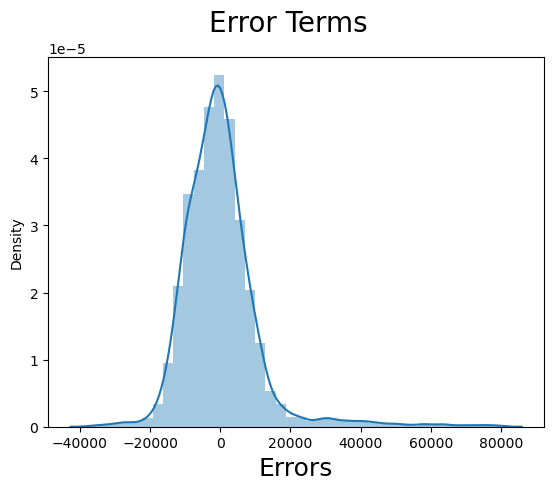

In [119]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_avg_train - y_avg_train_price), bins = 40)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### 8. Making Predictions Using the Final Model

In [120]:
X_avg_test[scale_columns] = scaler.transform(X_avg_test[scale_columns])

X_avg_test.head()

,Rating,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Height_in_cm,BodyType_Weight,Club_Hero,Alt_Pos_Count,Main_Position_CB,Main_Position_CDM,Main_Position_CF,Main_Position_CM,Main_Position_GK,Main_Position_LB,Main_Position_LM,Main_Position_LW,Main_Position_LWB,Main_Position_RB,Main_Position_RM,Main_Position_RW,Main_Position_RWB,Main_Position_ST,Run_Style_Controlled Explosive,Run_Style_Controlled Lengthy,Run_Style_Explosive,Run_Style_Lengthy,Run_Style_Mostly Explosive,Run_Style_Mostly Lengthy,Attack_Workrate_L,Attack_Workrate_M,Defense_Workrate_L,Defense_Workrate_M,BodyType_Text_Avg & Normal,BodyType_Text_Avg & Stocky,BodyType_Text_CR7,BodyType_Text_Courtois,BodyType_Text_Messi,BodyType_Text_Neymar,BodyType_Text_R9,BodyType_Text_Ronaldinho,BodyType_Text_Salah,BodyType_Text_Shaqiri,BodyType_Text_Short & Lean,BodyType_Text_Short & Normal,BodyType_Text_Short & Stocky,BodyType_Text_Tall & Lean,BodyType_Text_Tall & Normal,BodyType_Text_Tall & Stocky,BodyType_Text_Unique,League_Cat_Icons,League_Cat_LALIGA EA SPORTS,League_Cat_Ligue 1 Uber Eats,League_Cat_MLS,League_Cat_Other,League_Cat_Premier League,League_Cat_Serie A TIM,Nation_Cat_Brazil,Nation_Cat_England,Nation_Cat_France,Nation_Cat_Germany,Nation_Cat_Holland,Nation_Cat_Italy,Nation_Cat_Other,Nation_Cat_Portugal,Nation_Cat_Spain,Nation_Cat_United States,Alt_Pos_1_CB,Alt_Pos_1_CDM,Alt_Pos_1_CF,Alt_Pos_1_CM,Alt_Pos_1_LB,Alt_Pos_1_LM,Alt_Pos_1_LW,Alt_Pos_1_LWB,Alt_Pos_1_RB,Alt_Pos_1_RM,Alt_Pos_1_RW,Alt_Pos_1_RWB,Alt_Pos_1_ST,Alt_Pos_1_missing,Alt_Pos_2_CB,Alt_Pos_2_CDM,Alt_Pos_2_CF,Alt_Pos_2_CM,Alt_Pos_2_LB,Alt_Pos_2_LM,Alt_Pos_2_LW,Alt_Pos_2_LWB,Alt_Pos_2_RB,Alt_Pos_2_RM,Alt_Pos_2_RW,Alt_Pos_2_ST,Alt_Pos_2_missing,Alt_Pos_3_CDM,Alt_Pos_3_CF,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing,Gender_Male
7966,1.089407,-1.261143,-0.044373,1.119048,1.178803,0.776331,1.070598,-0.347075,1.442446,-0.081170,1.111231,-1.431565,-0.877966,-1.707460,0,-0.640296,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
5285,-0.743097,-1.261143,-0.044373,-0.351923,0.230039,-0.216870,-0.250148,-1.011823,-0.808186,-0.103828,-0.515724,-1.654966,0.529113,1.355335,0,-0.640296,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
3483,-0.010096,-1.261143,-0.044373,0.310014,0.599003,0.208787,0.514494,-0.956427,0.072496,-0.103828,0.144267,-1.195653,0.646369,1.027178,0,-0.640296,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
6785,-1.201224,0.524329,1.165299,0.236465,-0.613306,-0.642528,-0.250148,-1.067218,-1.493161,-0.104734,-0.853394,-0.119752,-0.291683,-0.285448,0,-0.640296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
5358,-0.743097,-0.368407,-0.044373,-1.087409,-1.245815,-1.068186,-0.528200,0.428464,0.170350,-0.104734,-0.792000,-0.060774,0.060086,1.245949,0,-0.640296,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1


In [121]:
# Adding constant variable to test dataframe
rfe = X_avg_test[col_avg]
rfe = sm.add_constant(rfe)

In [122]:
# Making predictions

y_avg_pred = lm.predict(rfe)

### 9. Model Evaluation

Let's now plot the graph for actual versus predicted values.

Text(0, 0.5, 'y_avg_pred')

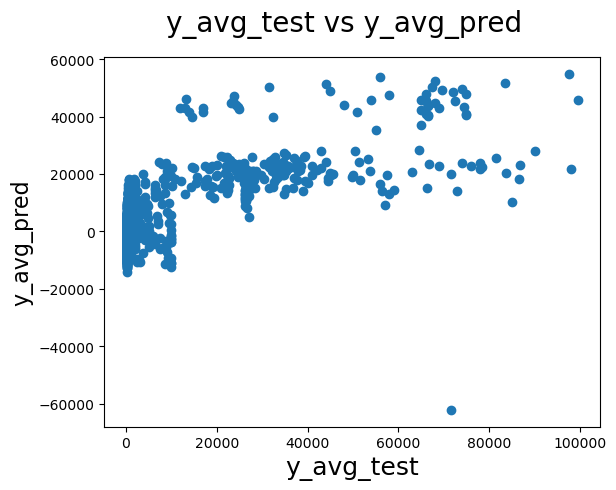

In [123]:
# Plotting y_avg_test and y_avg_pred to understand the spread

fig = plt.figure()
plt.scatter(y_avg_test, y_avg_pred)
fig.suptitle('y_avg_test vs y_avg_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_avg_test', fontsize = 18)                              # X-label
plt.ylabel('y_avg_pred', fontsize = 16)    

In [124]:
from sklearn.metrics import r2_score

In [125]:
r2_score(y_avg_test, y_avg_pred)

0.4938346042507129

### 10. Data segmentations

First I'm trying to divide the dataset to male and female players, then to defenders, midfielders and strikers

##### outlier treatment

In [11]:
# Calculate Q1 and Q3
Q1 = np.percentile(futbin_data.Price, 25)
Q3 = np.percentile(futbin_data.Price, 75)
IQR = Q3 - Q1

# Determine the lower and upper bounds
lower_bound = Q1 - 20 * IQR
upper_bound = Q3 + 20 * IQR

# Find outliers
outliers = futbin_data[(futbin_data.Price < lower_bound) | (futbin_data.Price > upper_bound)]

#Q1

#Q3

#outliers.info()

filtered_data = futbin_data[(futbin_data.Price >= lower_bound) & (futbin_data.Price <= upper_bound)]

filtered_data.Price.describe()

count     8405.000000
mean      6531.148126
std      14875.060627
min        200.000000
25%        200.000000
50%        400.000000
75%       1400.000000
max      90500.000000
Name: Price, dtype: float64

##### data segmentation based on position and gender

In [25]:
##### male-female split

male_players = filtered_data[filtered_data.Gender_Male == 1]

female_players = filtered_data[filtered_data.Gender_Male == 0]

#male_players.info()

#female_players.info()

##### goalkeepers

maleGK = male_players[male_players.Main_Position_GK == 1]

maleGK.info()

#maleGK.head()

#maleGK.Price.describe()

#maleGK.shape

#femaleGK.shape





femaleGK = female_players[female_players.Main_Position_GK == 1]

femaleGK.info()

#femaleGK.head()

##### defenders

maleD = male_players[(male_players.Main_Position_CB == 1) 
                     | (male_players.Main_Position_LB == 1)
                     | (male_players.Main_Position_LWB == 1)
                     | (male_players.Main_Position_RB == 1)
                     | (male_players.Main_Position_RWB == 1)]

maleD.info()

#maleD.head()

femaleD = female_players[(female_players.Main_Position_CB == 1) 
                     | (female_players.Main_Position_LB == 1)
                     | (female_players.Main_Position_LWB == 1)
                     | (female_players.Main_Position_RB == 1)
                     | (female_players.Main_Position_RWB == 1)]

femaleD.info()

#femaleD.head()

##### midfielders

maleM = male_players[(male_players.Main_Position_CDM == 1) 
                     | (male_players.Main_Position_CM == 1)
                     | (male_players.Main_Position_LM == 1)
                     | (male_players.Main_Position_LW == 1)
                     | (male_players.Main_Position_RM == 1)
                     | (male_players.Main_Position_RW == 1) 
                     | (
                         (male_players.Main_Position_CB == 0) 
                         & (male_players.Main_Position_LB == 0)
                         & (male_players.Main_Position_LWB == 0)
                         & (male_players.Main_Position_RB == 0)
                         & (male_players.Main_Position_RWB == 0)
                         & (male_players.Main_Position_GK == 0)
                         & (male_players.Main_Position_CF == 0) 
                         & (male_players.Main_Position_ST == 0)
                         & (male_players.Main_Position_CDM == 0)
                         & (male_players.Main_Position_CM == 0)
                         & (male_players.Main_Position_LM == 0)
                         & (male_players.Main_Position_LW == 0)
                         & (male_players.Main_Position_RM == 0)
                         & (male_players.Main_Position_RW == 0)
                       )]

maleM.info()

#maleM.head()

femaleM = female_players[(female_players.Main_Position_CDM == 1) 
                     | (female_players.Main_Position_CM == 1)
                     | (female_players.Main_Position_LM == 1)
                     | (female_players.Main_Position_LW == 1)
                     | (female_players.Main_Position_RM == 1)
                     | (female_players.Main_Position_RW == 1) 
                     | (
                         (female_players.Main_Position_CB == 0) 
                         & (female_players.Main_Position_LB == 0)
                         & (female_players.Main_Position_LWB == 0)
                         & (female_players.Main_Position_RB == 0)
                         & (female_players.Main_Position_RWB == 0)
                         & (female_players.Main_Position_GK == 0)
                         & (female_players.Main_Position_CF == 0) 
                         & (female_players.Main_Position_ST == 0)
                         & (female_players.Main_Position_CDM == 0)
                         & (female_players.Main_Position_CM == 0)
                         & (female_players.Main_Position_LM == 0)
                         & (female_players.Main_Position_LW == 0)
                         & (female_players.Main_Position_RM == 0)
                         & (female_players.Main_Position_RW == 0)
                       )]

femaleM.info()

#femaleM.head()

##### Forwarders

maleF = male_players[(male_players.Main_Position_CF == 1) 
                     | (male_players.Main_Position_ST == 1)]

maleF.info()

#maleF.head()

femaleF = female_players[(female_players.Main_Position_CF == 1) 
                     | (female_players.Main_Position_ST == 1)]

femaleF.info()

##### check the numbers to make sure that there are no mising players from the segmented datasets

#all checks should be True

#len(filtered_data) == len(male_players) + len(female_players)

#len(male_players) == len(maleGK) + len(maleD) + len(maleM) + len(maleF)

#len(female_players) == len(femaleGK) + len(femaleD) + len(femaleM) + len(femaleF)

#len(maleM)







<class 'pandas.core.frame.DataFrame'>
Int64Index: 1935 entries, 52 to 7688
Columns: 115 entries, Name to Gender_Male
dtypes: float64(2), int64(112), object(1)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 7778 to 8993
Columns: 115 entries, Name to Gender_Male
dtypes: float64(2), int64(112), object(1)
memory usage: 162.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2764 entries, 103 to 7691
Columns: 115 entries, Name to Gender_Male
dtypes: float64(2), int64(112), object(1)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 7726 to 8996
Columns: 115 entries, Name to Gender_Male
dtypes: float64(2), int64(112), object(1)
memory usage: 356.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 107 to 7694
Columns: 115 entries, Name to Gender_Male
dtypes: float64(2), int64(112), object(1)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 7727 to 8995
Columns: 11

In [13]:
male_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7167 entries, 36 to 7694
Columns: 115 entries, Name to Gender_Male
dtypes: float64(2), int64(112), object(1)
memory usage: 6.3+ MB


In [14]:
female_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1238 entries, 7705 to 8996
Columns: 115 entries, Name to Gender_Male
dtypes: float64(2), int64(112), object(1)
memory usage: 1.1+ MB


##### new linear model function for testing all the segments of the original dataset

In [15]:
def linear_model(dataset):
    # 1) train-test split
    # Putting feature variable to X
    X = dataset.drop(['Name','Price'], axis=1)
    # Putting response variable to y
    y = dataset['Price']
    # Splitting the maleGK data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)
    
    # 2) feature scaling
    # columns to be scaled
    scale_columns = ['Rating','Skills_Star','Weak_Foot_Star', 'Pace / Diving', 'Shooting / Handling', 'Passing / Kicking',
                'Dribbling / Reflexes', 'Defense / Speed', 'Physical / Positioning', 'Popularity', 'Base_Stats',
                'Ingame_Stats', 'Height_in_cm', 'BodyType_Weight', 'Alt_Pos_Count']
    scaler = StandardScaler()
    X_train[scale_columns] = scaler.fit_transform(X_train[scale_columns])
    
    # 3) linear regression model
    #model = LinearRegression()
    #rfe = RFE(estimator=linreg, n_features_to_select=15)             # running RFE with 15 variables as output
    #rfe = rfe.fit(X_train, y_train)
    #col = X_train.columns[rfe.support_]
    
    # 4) linear model implementation
    # Creating X_train dataframe with RFE selected variables
    #rfe = X_train[col]
    # Adding a constant variable   
    X_train = sm.add_constant(X_train)
    # Running the linear model
    lm = sm.OLS(y_train,X_train).fit()
    #lm = sm.RLM(y_train,X_train, M=sm.robust.norms.HuberT()).fit()
    #Let's see the summary of our linear model
    print(lm.summary())
    
    # 5) residual analysis on the train data
    y_train_price = lm.predict(X_train)
    
    # Plot the histogram of the error terms
    fig = plt.figure()
    sns.distplot((y_train - y_train_price), bins = 40)
    fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
    plt.xlabel('Errors', fontsize = 18)                         # X-label
    
    # 6) making prediction based on the final model
    X_test[scale_columns] = scaler.transform(X_test[scale_columns])
    # Adding constant variable to test dataframe
    #rfe = X_test[col]
    X_test = sm.add_constant(X_test)
    # Making predictions
    y_pred = lm.predict(X_test)
    
    # 7) model evaluation
    # Plotting y_avg_test and y_avg_pred to understand the spread
    fig = plt.figure()
    plt.scatter(y_test, y_pred)
    fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
    plt.xlabel('y_test', fontsize = 18)                              # X-label
    plt.ylabel('y_pred', fontsize = 16) 
    
    # 8) metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R-squared: {r2}")

##### remove unnecessary columns

In [403]:
#def narrow(data):
#    return data.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,114]]

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     79.61
Date:                Sun, 03 Nov 2024   Prob (F-statistic):               0.00
Time:                        08:56:19   Log-Likelihood:                -14822.
No. Observations:                1548   AIC:                         2.973e+04
Df Residuals:                    1504   BIC:                         2.997e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Rating      

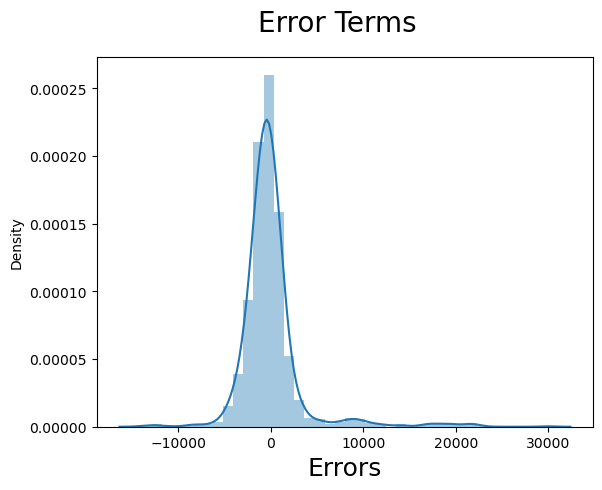

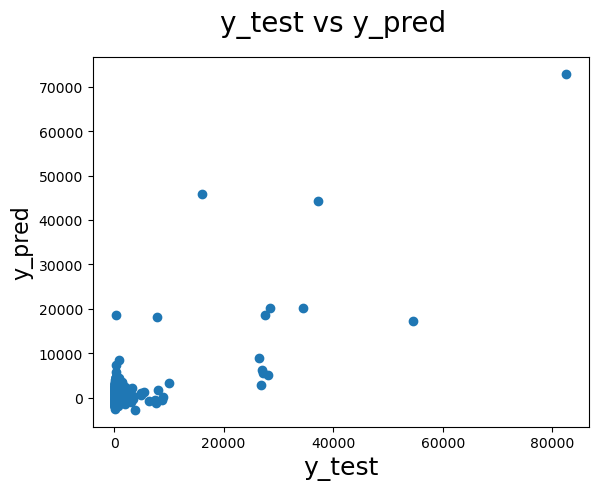

In [16]:
%%time
#n = narrow(maleGK)
linear_model(maleGK)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     42.87
Date:                Sun, 03 Nov 2024   Prob (F-statistic):               0.00
Time:                        08:57:36   Log-Likelihood:                -23017.
No. Observations:                2211   AIC:                         4.619e+04
Df Residuals:                    2131   BIC:                         4.665e+04
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Rating      

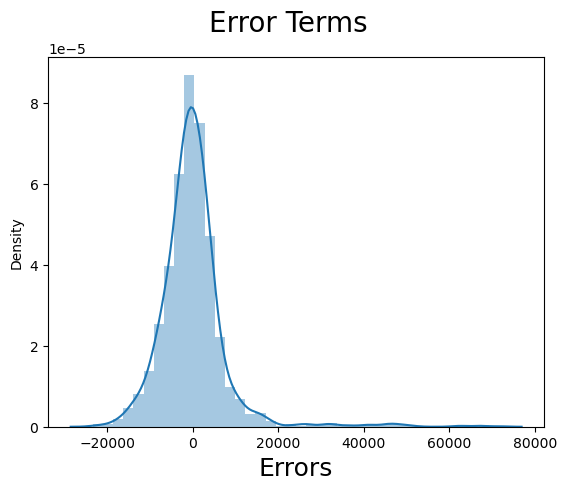

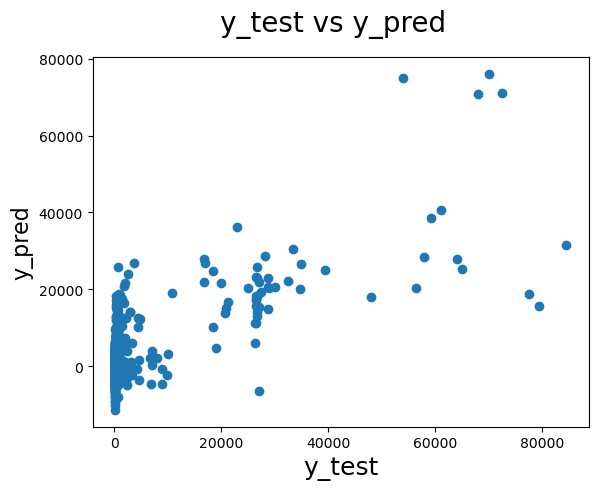

In [17]:
%%time
linear_model(maleD)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     29.55
Date:                Sun, 03 Nov 2024   Prob (F-statistic):          6.20e-269
Time:                        08:57:43   Log-Likelihood:                -16836.
No. Observations:                1571   AIC:                         3.386e+04
Df Residuals:                    1479   BIC:                         3.435e+04
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Rating      

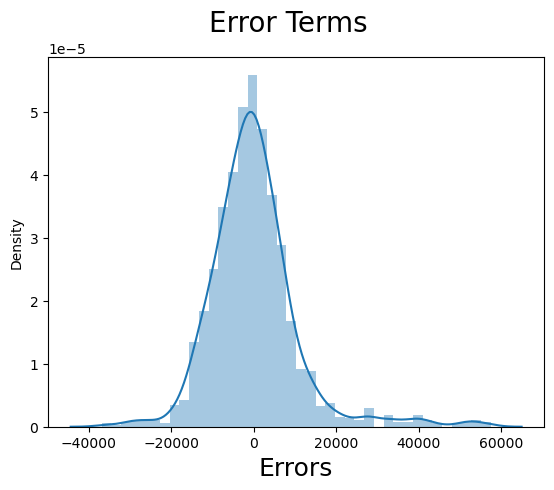

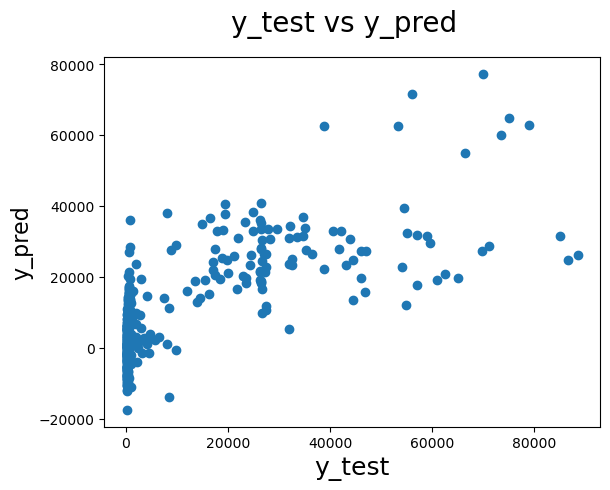

In [18]:
%%time
linear_model(maleM)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     14.77
Date:                Sun, 03 Nov 2024   Prob (F-statistic):           1.03e-67
Time:                        08:57:46   Log-Likelihood:                -4318.8
No. Observations:                 403   AIC:                             8776.
Df Residuals:                     334   BIC:                             9052.
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Rating      

Mean Absolute Percentage Error (MAPE): 571.51%
MAE: 7625.735263215021
MSE: 114755225.97483988
RMSE: 10712.386567653348
R-squared: 0.7456270413081119
CPU times: total: 531 ms
Wall time: 333 ms


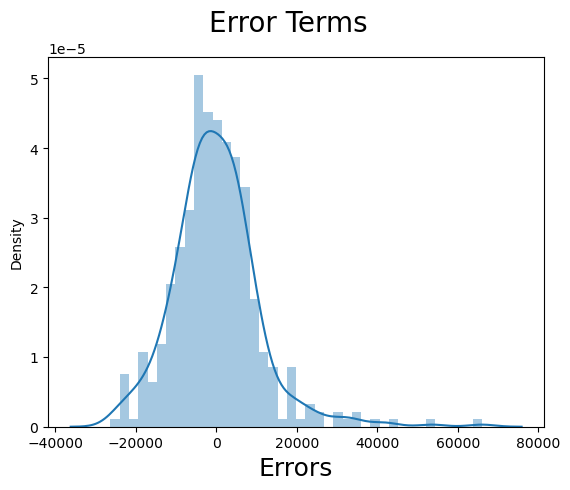

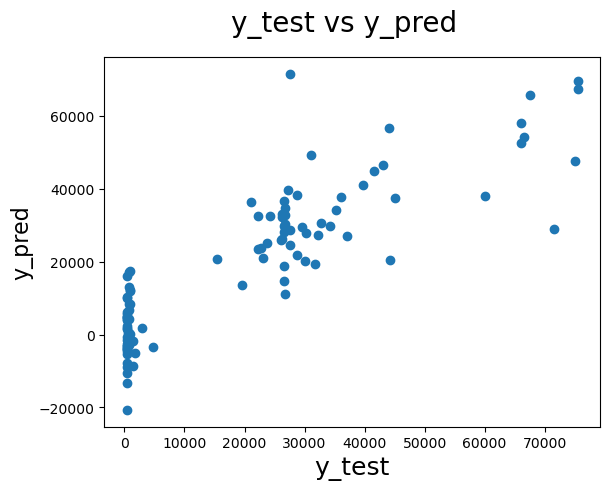

In [19]:
%%time
linear_model(maleF)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     50.31
Date:                Sun, 03 Nov 2024   Prob (F-statistic):           1.71e-51
Time:                        08:57:51   Log-Likelihood:                -1266.2
No. Observations:                 143   AIC:                             2588.
Df Residuals:                     115   BIC:                             2671.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Rating      

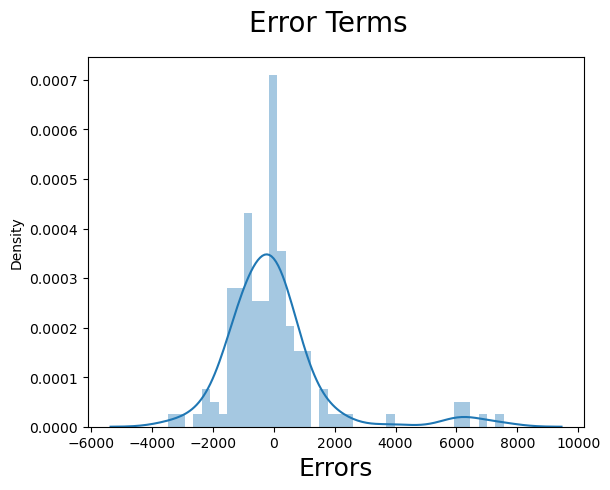

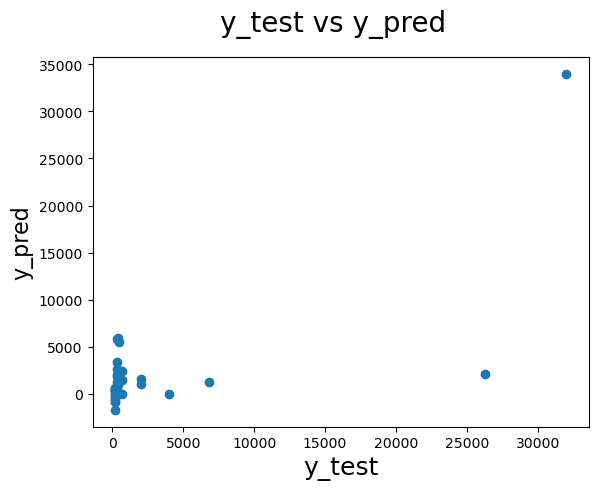

In [20]:
%%time
linear_model(femaleGK)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     6.766
Date:                Sun, 03 Nov 2024   Prob (F-statistic):           2.70e-28
Time:                        08:58:00   Log-Likelihood:                -3224.1
No. Observations:                 314   AIC:                             6574.
Df Residuals:                     251   BIC:                             6811.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Rating      

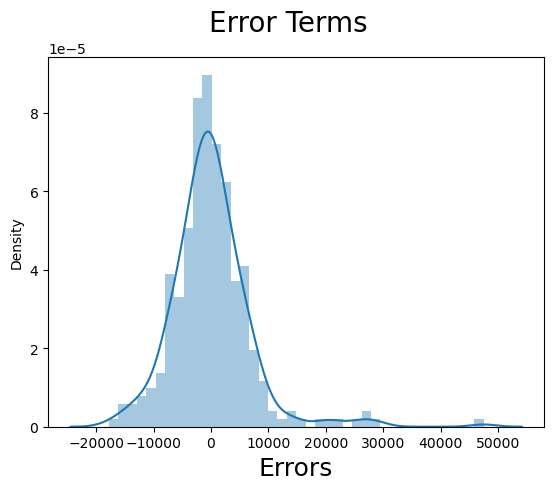

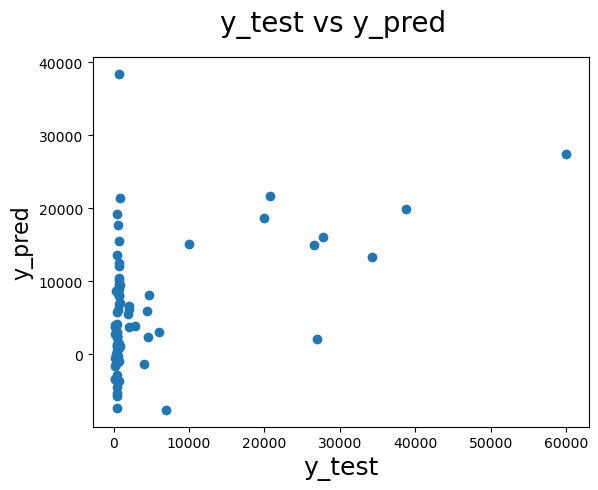

In [21]:
%%time
linear_model(femaleD)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     9.451
Date:                Sun, 03 Nov 2024   Prob (F-statistic):           7.00e-50
Time:                        08:58:05   Log-Likelihood:                -4474.1
No. Observations:                 427   AIC:                             9098.
Df Residuals:                     352   BIC:                             9403.
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Rating      

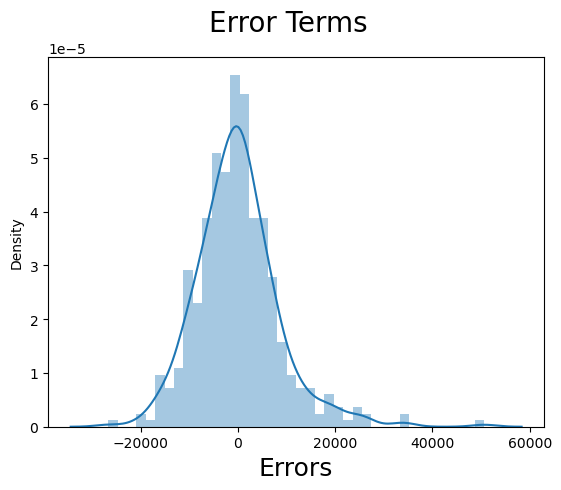

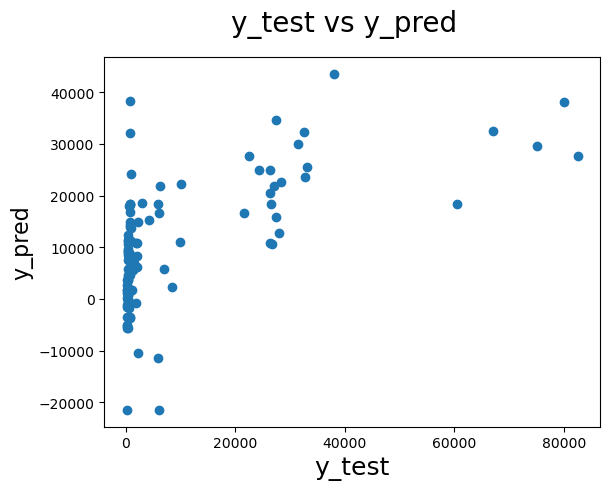

In [22]:
%%time
linear_model(femaleM)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     6.311
Date:                Sun, 03 Nov 2024   Prob (F-statistic):           1.42e-10
Time:                        08:58:18   Log-Likelihood:                -1087.8
No. Observations:                 105   AIC:                             2276.
Df Residuals:                      55   BIC:                             2408.
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Rating      

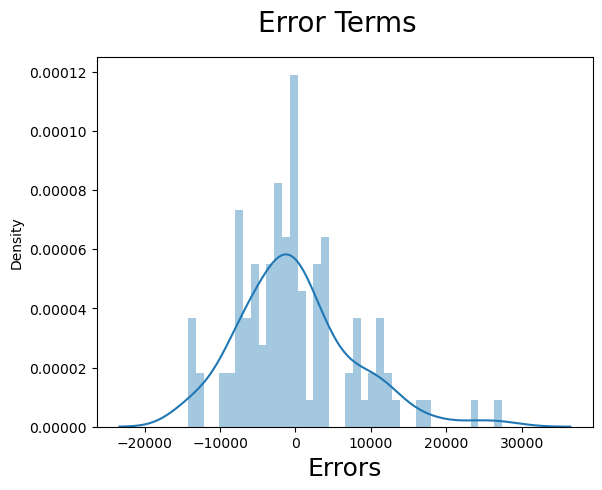

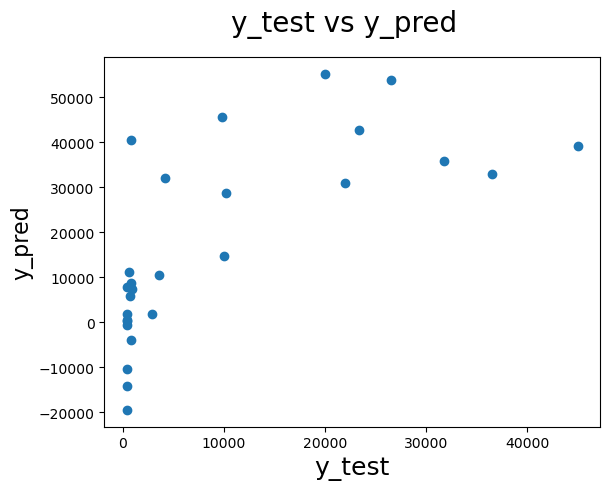

In [24]:
%%time
linear_model(femaleF)

### Prediction Results on a test dataset

#### maleGK
- Mean Absolute Percentage Error (MAPE): 441.77%
- MAE: 2038.3290324692416
- MSE: 18358920.65068106
- RMSE: 4284.731105994991
- R-squared: 0.5952838758416633

#### maleD
- Mean Absolute Percentage Error (MAPE): 1049.20%
- MAE: 5298.957690542906
- MSE: 71292705.55396739
- RMSE: 8443.500787822986
- R-squared: 0.5204789348053647

#### maleM
- Mean Absolute Percentage Error (MAPE): 1219.19%
- MAE: 8362.30088772885
- MSE: 151921737.92927495
- RMSE: 12325.653651197366
- R-squared: 0.5439470225678995

#### maleF
- Mean Absolute Percentage Error (MAPE): 571.51%
- MAE: 7625.735263215021
- MSE: 114755225.97483988
- RMSE: 10712.386567653348
- R-squared: 0.7456270413081119

#### femaleGK
- Mean Absolute Percentage Error (MAPE): 339.97%
- MAE: 2148.437013416196
- MSE: 21032994.474371824
- RMSE: 4586.174274313158
- R-squared: 0.5254057723312588

#### femaleD
- Mean Absolute Percentage Error (MAPE): 888.19%
- MAE: 9662.572705164594
- MSE: 197369294.1659516
- RMSE: 14048.818248021846
- R-squared: 0.3571611856199032

#### femaleM
- Mean Absolute Percentage Error (MAPE): 1005.11%
- MAE: 9662.572705164594
- MSE: 197369294.1659516
- RMSE: 14048.818248021846
- R-squared: 0.3571611856199032

#### femaleF
- Mean Absolute Percentage Error (MAPE): 938.21%
- MAE: 12181.10199628304
- MSE: 280947322.73328936
- RMSE: 16761.483309459498
- R-squared: -0.7013820211818407

### prediction for the Rating

In [8]:
def linear_model_rating(dataset):
    # 1) train-test split
    # Putting feature variable to X
    X = dataset.drop(['Name','Rating'], axis=1)
    # Putting response variable to y
    y = dataset['Rating']
    # Splitting the maleGK data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)
    
    # 2) feature scaling
    # columns to be scaled
    scale_columns = ['Price','Skills_Star','Weak_Foot_Star', 'Pace / Diving', 'Shooting / Handling', 'Passing / Kicking',
                'Dribbling / Reflexes', 'Defense / Speed', 'Physical / Positioning', 'Popularity', 'Base_Stats',
                'Ingame_Stats', 'Height_in_cm', 'BodyType_Weight', 'Alt_Pos_Count']
    scaler = StandardScaler()
    X_train[scale_columns] = scaler.fit_transform(X_train[scale_columns])
    
    # 3) linear regression model
    #model = LinearRegression()
    #rfe = RFE(estimator=linreg, n_features_to_select=15)             # running RFE with 15 variables as output
    #rfe = rfe.fit(X_train, y_train)
    #col = X_train.columns[rfe.support_]
    
    # 4) linear model implementation
    # Creating X_train dataframe with RFE selected variables
    #rfe = X_train[col]
    # Adding a constant variable   
    X_train = sm.add_constant(X_train)
    # Running the linear model
    lm = sm.OLS(y_train,X_train).fit()
    #lm = sm.RLM(y_train,X_train, M=sm.robust.norms.HuberT()).fit()
    #Let's see the summary of our linear model
    print(lm.summary())
    
    # 5) residual analysis on the train data
    y_train_rating = lm.predict(X_train)
    
    # Plot the histogram of the error terms
    fig = plt.figure()
    sns.distplot((y_train - y_train_rating), bins = 40)
    fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
    plt.xlabel('Errors', fontsize = 18)                         # X-label
    
    # 6) making prediction based on the final model
    X_test[scale_columns] = scaler.transform(X_test[scale_columns])
    # Adding constant variable to test dataframe
    #rfe = X_test[col]
    X_test = sm.add_constant(X_test)
    # Making predictions
    y_pred = lm.predict(X_test)
    
    # 7) model evaluation
    # Plotting y_avg_test and y_avg_pred to understand the spread
    fig = plt.figure()
    plt.scatter(y_test, y_pred)
    fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
    plt.xlabel('y_test', fontsize = 18)                              # X-label
    plt.ylabel('y_pred', fontsize = 16) 
    
    # 8) metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R-squared: {r2}")

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1384.
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:10:02   Log-Likelihood:                -16181.
No. Observations:                7197   AIC:                         3.259e+04
Df Residuals:                    7085   BIC:                         3.336e+04
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

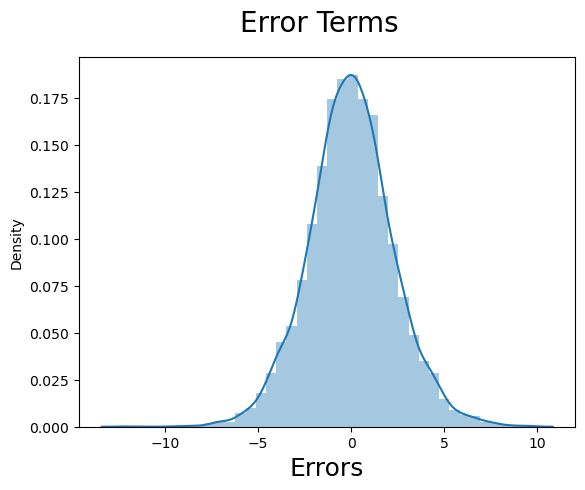

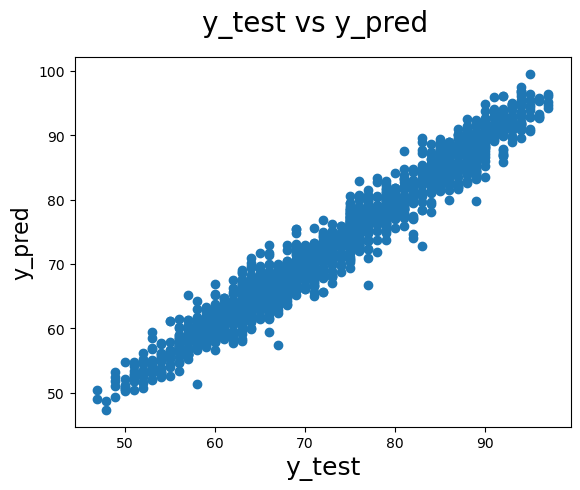

In [9]:
%%time
linear_model_rating(futbin_data)